In [42]:
from minisom import MiniSom
import numpy as np
import pandas as pd
from DataSet import DataSet
from Square import *
import os

current_dir = os.getcwd()

data = pd.read_csv(f'{current_dir}/SomXYZ.csv')
data = data.values
#moim zdaniem chyba nie potrzeba tutaj normalizować danych, ewentualnie po zmianach wartości x oraz y z jest zawsze -1 do 1
print(data.shape)

(10000, 3)


In [43]:
dataSet = DataSet(data)
dataSet.group_points_into_squares(10,10)
dataSet.randomize(50)
dataSet.group_normal_vectors(2)

In [44]:
bad_square = dataSet.squares2d[0,0]

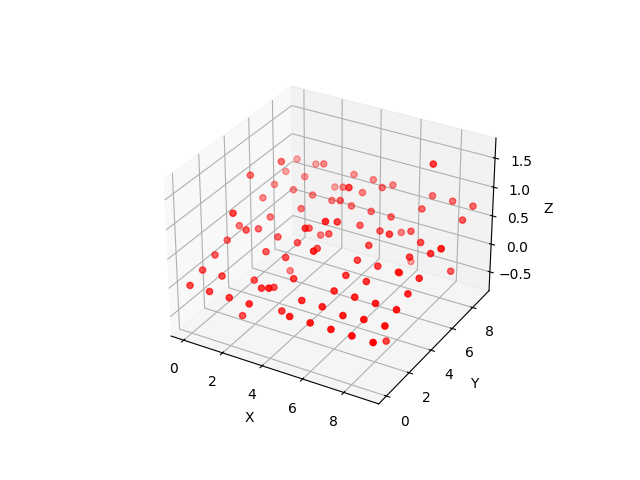

In [45]:
%matplotlib ipympl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') 

# Wykres punktowy 3D
ax.scatter(bad_square.points[:,0], bad_square.points[:,1], bad_square.points[:,2], c='r', marker='o')  # c - kolor,  marker - kształt punktoru

# Ustawianie etykiet osi
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Wyświetlenie wykresu
plt.show()

TO EDYTOWAĆ DLA TRENINGU

In [46]:
som_3dim = len(dataSet.normals_to_train[0]) #ilość wag w neuronie
som_grid_size = 3

normal_vectors_to_train = dataSet.normals_to_train #tworzenie listy składającej się z wektorów gotowych do treningu 
labels = dataSet.labels
label_names = {0: 'Dobre', 1: 'Złe'}

In [47]:
print("data", normal_vectors_to_train[:2])
print("labels", labels[:2])

data [array([-0.        ,  0.07888878, -0.99688342, -0.        ,  0.02575035,
       -0.9996684 , -0.        ,  0.07888878, -0.99688342, -0.        ,
        0.02575035, -0.9996684 ]), array([-0.        ,  0.02575035, -0.9996684 , -0.        , -0.04597636,
       -0.99894253, -0.        ,  0.02575035, -0.9996684 , -0.        ,
       -0.04597636, -0.99894253])]
labels [1, 0]


In [48]:
som = MiniSom(som_grid_size, som_grid_size, som_3dim, random_seed=42)
som.train(normal_vectors_to_train, 100000)

Koniec edytowania

In [49]:
print(som.winner(dataSet.normals_to_train[0]))

(0, 2)


In [50]:
#tworzenie mapy kolorów
som_colors = np.empty((som_grid_size, som_grid_size), dtype='object')
color_idx = 0
for i in range(som_grid_size):
    for j in range (som_grid_size):
        som_colors[i,j] = colors[color_idx]
        color_idx+= 1
print(som_colors[1][0])

#FF34FF


In [51]:
#kolorowanie punktów sinusoidy
# winner_pos = som.winner(bad_square.normal_vector)
# col = som_colors[winner_pos[0], winner_pos[1]]
# print(col)
# bad_square.color_my_points(col)
# for square in squares:
#     winner_pos = som.winner(bad_square.normal_vector)
#     col = som_colors[winner_pos[0], winner_pos[1]]
#     square.color_my_points(col)


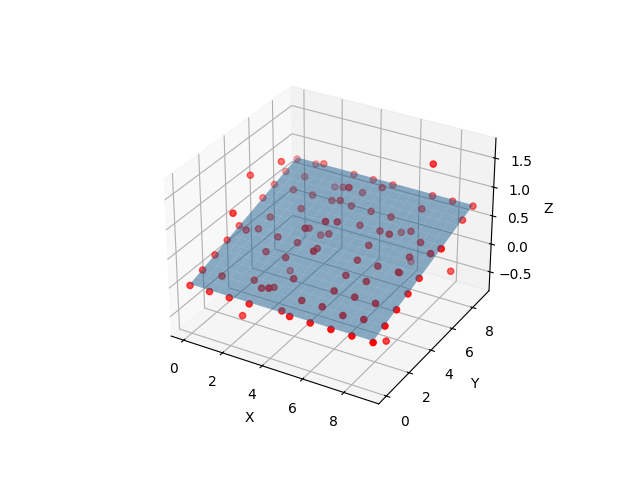

In [52]:
normal_x, normal_y, normal_Z = dataSet.bad_squares[0].normal_vector
centroid = bad_square.points.mean(axis=0)
# Create grid values
x = np.linspace(min(bad_square.points[:,0]), max(bad_square.points[:,0]),20) #x i y są zamienione miejscami ???
y = np.linspace(min(bad_square.points[:,1]), max(bad_square.points[:,1]),20)
xx, yy = np.meshgrid(x, y)
d = normal_x * centroid[0] + normal_y * centroid[1] + normal_Z * centroid[2]
# Calculate Z values
Z = (-normal_x * xx - normal_y * yy + d) / normal_Z

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(bad_square.points[:,0], bad_square.points[:,1], bad_square.points[:,2], c='r', marker='o')  # c - kolor,  marker - kształt punktoru

ax.plot_surface(xx, yy, Z, alpha=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [53]:
# import csv
# def print_out_squares(squares): #zmien nazwe
#     formatted_numbers = []
#     with open('numbers.csv', 'w', newline='') as csvfile:
#         for suqare in squares:
#             points_to_print = suqare.colored_points
#             writer = csv.writer(csvfile)
#             for point in points_to_print:
#                 for num in point:
#                     formatted_numbers.append("{}".format(num))
#                 writer.writerow(formatted_numbers)
#                 formatted_numbers = []
# print_out_squares(squares)

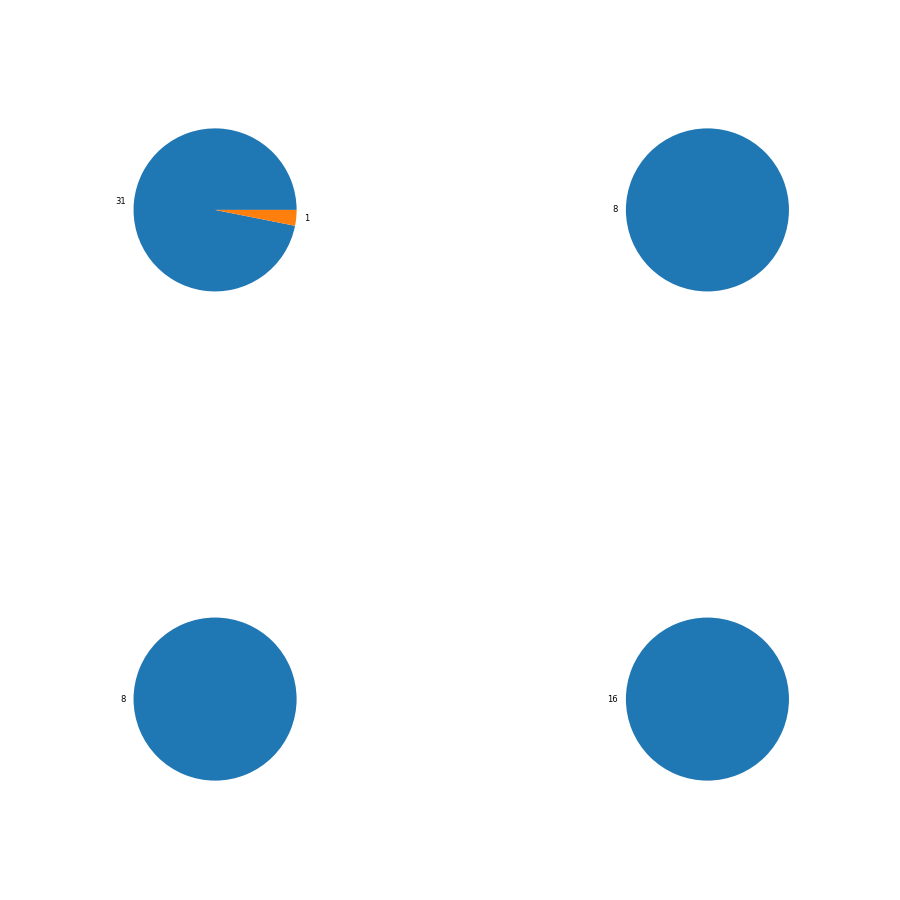

In [54]:
import matplotlib.gridspec as gridspec

labels_map = som.labels_map(normal_vectors_to_train, [label_names[t] for t in labels])

fig = plt.figure(figsize=(9, 9))
the_grid = gridspec.GridSpec(som_grid_size, som_grid_size, fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names.values()]
    plt.subplot(the_grid[som_grid_size-1-position[1],
                         position[0]], aspect=1)
    patches, autotexts = plt.pie(label_fracs, textprops={'fontsize': 6})  # Change here

    # Add labels to show the counts
    for t, count in zip(autotexts, label_fracs):
        if count > 0:  # Only display the number if the count is greater than zero
            t.set_text(f"{count:.0f}") 

plt.legend(patches, label_names.values(), bbox_to_anchor=(5.5, 9.5), ncol=3)
plt.show()